**Imports and Global Settings**

In this cell, we import the necessary libraries (TensorFlow, NumPy, Matplotlib, etc.) and set global configurations for image processing, such as batch size and image dimensions.


In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.data import AUTOTUNE
import glob, os
import math
from PIL import Image
import scienceplots

keras.backend.clear_session()

DATASET_BUFFER_SIZE = 1000
DATASET_BATCH_SIZE = 64

IMG_WIDTH = 256
IMG_HEIGHT = 256


2025-06-02 01:01:30.250545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 01:01:30.251250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 01:01:30.255364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 01:01:30.265401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748822490.281768 2275951 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748822490.28

**Data Augmentation Layers**

Here we define a sequence of data augmentation layers that will be applied only during training to improve model robustness. This includes random rotations, zoom, contrast, and brightness adjustments.


In [2]:
data_augment = tf.keras.Sequential([
    layers.RandomRotation(factor=1.0, fill_mode='reflect'),
    layers.RandomZoom(0.1, 0.1, fill_mode='reflect'),
    layers.RandomContrast(0.05),
    layers.RandomBrightness(0.05),
])


2025-06-02 01:01:32.641355: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Preprocessing Function for Paired Images**

This function loads a concatenated image (left half = rain, right half = IR), splits it into input (IR) and target (rain), applies augmentations if training, resizes both halves, and performs per-image z-score normalization.


In [3]:
def preprocess_pair(path, training):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=1)
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :]
    inp = img[:, w:, :]

    if training:
        pair = tf.concat([inp, real], axis=2)
        pair = data_augment(pair)
        inp, real = tf.split(pair, num_or_size_splits=2, axis=2)

    inp = tf.image.resize(inp, [IMG_WIDTH, IMG_HEIGHT], method='bilinear')
    real = tf.image.resize(real, [IMG_WIDTH, IMG_HEIGHT], method='bilinear')

    inp_mean, inp_var = tf.nn.moments(inp, axes=[0, 1])
    real_mean, real_var = tf.nn.moments(real, axes=[0, 1])
    inp = (inp - inp_mean) / tf.sqrt(inp_var + 1e-6)
    real = (real - real_mean) / tf.sqrt(real_var + 1e-6)

    return inp, real


**Creating TensorFlow Datasets**

We use `tf.data.Dataset` to list files matching a pattern, apply the preprocessing function, batch the data, and prefetch for performance. We create separate datasets for training (with shuffling) and testing (without shuffling).


In [4]:
def make_ds(pattern, training):
    ds = tf.data.Dataset.list_files(pattern)
    if training:
        ds = ds.shuffle(DATASET_BUFFER_SIZE)
    ds = ds.map(lambda p: preprocess_pair(p, training), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(DATASET_BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_dataset = make_ds('./data/TCIRRP/train/*.jpg', training=True)
test_dataset = make_ds('./data/TCIRRP/test1k/*.jpg', training=False)


**Autoencoder Model Definition**

We define an `Autoencoder` class inheriting from `Model`. The encoder downsamples the input three times and maps it to a latent space. The decoder upsamples from that latent space back to the original image size using transpose convolution layers.


In [5]:
LATENT_DIMENSIONS = 32

class Autoencoder(Model):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
            layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Flatten(),
            layers.Dense(LATENT_DIMENSIONS, activation='relu'),
        ])

        self.bw = math.ceil(IMG_WIDTH / 2**3)
        self.bh = math.ceil(IMG_HEIGHT / 2**3)
        self.bc = 128

        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(LATENT_DIMENSIONS,)),
            layers.Dense(self.bw * self.bh * self.bc, use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Reshape((self.bw, self.bh, self.bc)),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2DTranspose(1, 3, strides=2, padding='same'),
        ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded


**Model Instantiation and Summaries**

We check if a saved checkpoint exists. If it does, load and evaluate the model. Otherwise, create a new instance, compile it using Adam optimizer and MSE loss, and display summaries for the encoder and decoder.


In [6]:
input_epoch = 0
input_model_path = f"60k-{input_epoch}Epochs-64Batch-32Lat.keras"
output_epoch = 2
output_model_path = f"60k-{output_epoch}Epochs-64Batch-32Lat.keras"
log_dir = "logs/fit/autoencoder-60k-64Batch-32Lat"

if os.path.exists(input_model_path):
    autoencoder = load_model(input_model_path, custom_objects={'Autoencoder': Autoencoder})
    autoencoder.evaluate(test_dataset, verbose=2)
else:
    autoencoder = Autoencoder()
    autoencoder.compile(
        optimizer='adam',
        loss=losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

autoencoder.encoder.summary()
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     4,194,336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,232 (16.35 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 131072)         │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,811,425 (18.35 MB)

 Trainable params: 4,549,089 (17.35 MB)

 Non-trainable params: 262,336 (1.00 MB)

**Training the Autoencoder**

Set up callbacks for model checkpointing and TensorBoard logging, then train the model using the training and validation datasets.


In [7]:
save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=output_model_path,
    verbose=2,
    monitor='val_loss',
    save_best_only=True
)

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=5,
    write_graph=True,
)

autoencoder.fit(
    train_dataset,
    epochs=output_epoch,
    initial_epoch=input_epoch,
    validation_data=test_dataset,
    callbacks=[save_callback, tensorboard_cb],
)


Epoch 1/2
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6796 - mean_absolute_error: 0.4376
Epoch 1: val_loss improved from inf to 0.58455, saving model to 60k-2Epochs-64Batch-32Lat.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 1193s 1s/step - loss: 0.6795 - mean_absolute_error: 0.4375 - val_loss: 0.5845 - val_mean_absolute_error: 0.4209
Epoch 2/2
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5759 - mean_absolute_error: 0.3872
Epoch 2: val_loss improved from 0.58455 to 0.57436, saving model to 60k-2Epochs-64Batch-32Lat.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 1253s 1s/step - loss: 0.5759 - mean_absolute_error: 0.3872 - val_loss: 0.5744 - val_mean_absolute_error: 0.4174


**Evaluation and Visualization of Reconstructions**

After training, evaluate the model on the test dataset and visualize a few examples: input (IR), predicted rain, and ground truth rain side by side.


Final evaluation on test dataset:
15/15 - 8s - 520ms/step - loss: 0.5728 - mean_absolute_error: 0.4167


2025-06-02 01:42:29.268353: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-02 01:42:32.625886: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


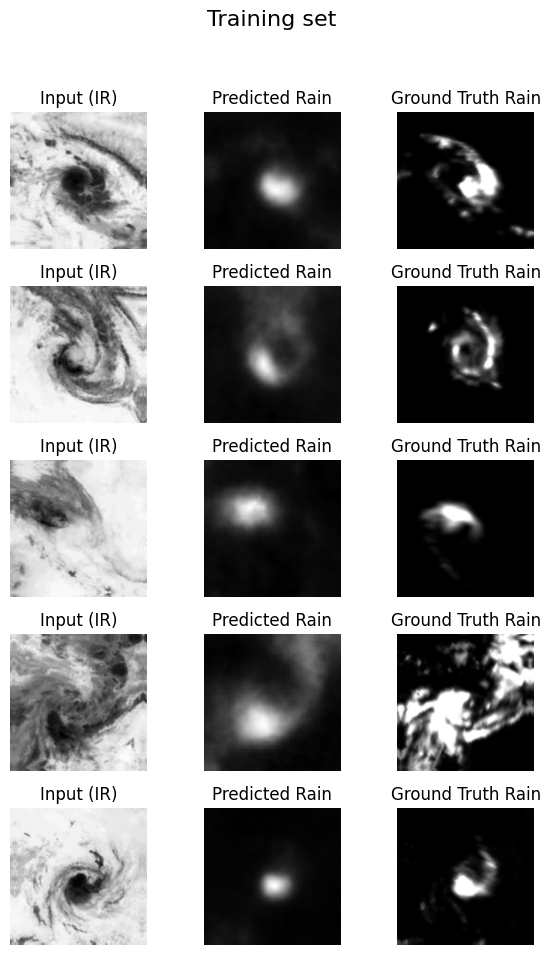

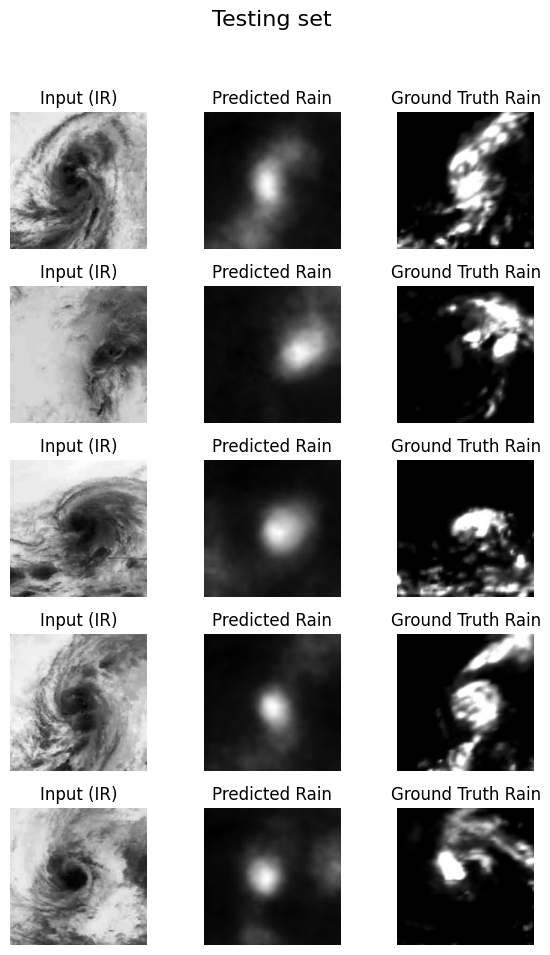

In [8]:
print("Final evaluation on test dataset:")
autoencoder.evaluate(test_dataset, verbose=2)

num_tests = 5

for name, dataset in [("Training set", train_dataset), ("Testing set", test_dataset)]:
    x_input = []
    x_real = []
    for input_batch, real_batch in dataset.take(num_tests):
        x_input.extend(input_batch)
        x_real.extend(real_batch)
    x_input = tf.stack(x_input)
    x_real = tf.stack(x_real)

    encoded_imgs = autoencoder.encoder(x_input).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    plt.figure(figsize=(6, num_tests * 2))
    plt.suptitle(name, fontsize=16)
    for i in range(num_tests):
        ax = plt.subplot(num_tests, 3, i * 3 + 1)
        plt.imshow(x_input[i].numpy(), cmap="gray")
        ax.set_title("Input (IR)")
        ax.axis("off")

        ax = plt.subplot(num_tests, 3, i * 3 + 2)
        plt.imshow(decoded_imgs[i], cmap="gray")
        ax.set_title("Predicted Rain")
        ax.axis("off")

        ax = plt.subplot(num_tests, 3, i * 3 + 3)
        plt.imshow(x_real[i].numpy(), cmap="gray")
        ax.set_title("Ground Truth Rain")
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Analysis of Non-Black Pixel Fraction Distribution**

Compute the fraction of non-black pixels (intensity > 0) for each rain image. Fit a normal distribution to select representative subsets and save file paths for these subsets. Plot the histogram with the fitted curve.


0–0.05     -> selecting 687 images
0.05–0.24  -> selecting 11649 images
0.24–0.4   -> selecting 20019 images
0.4–0.967  -> selecting 24448 images
Mean (μ) = 0.3681, Std Dev (σ) = 0.1683
Saved zoomed histogram as white_fraction_fine.png


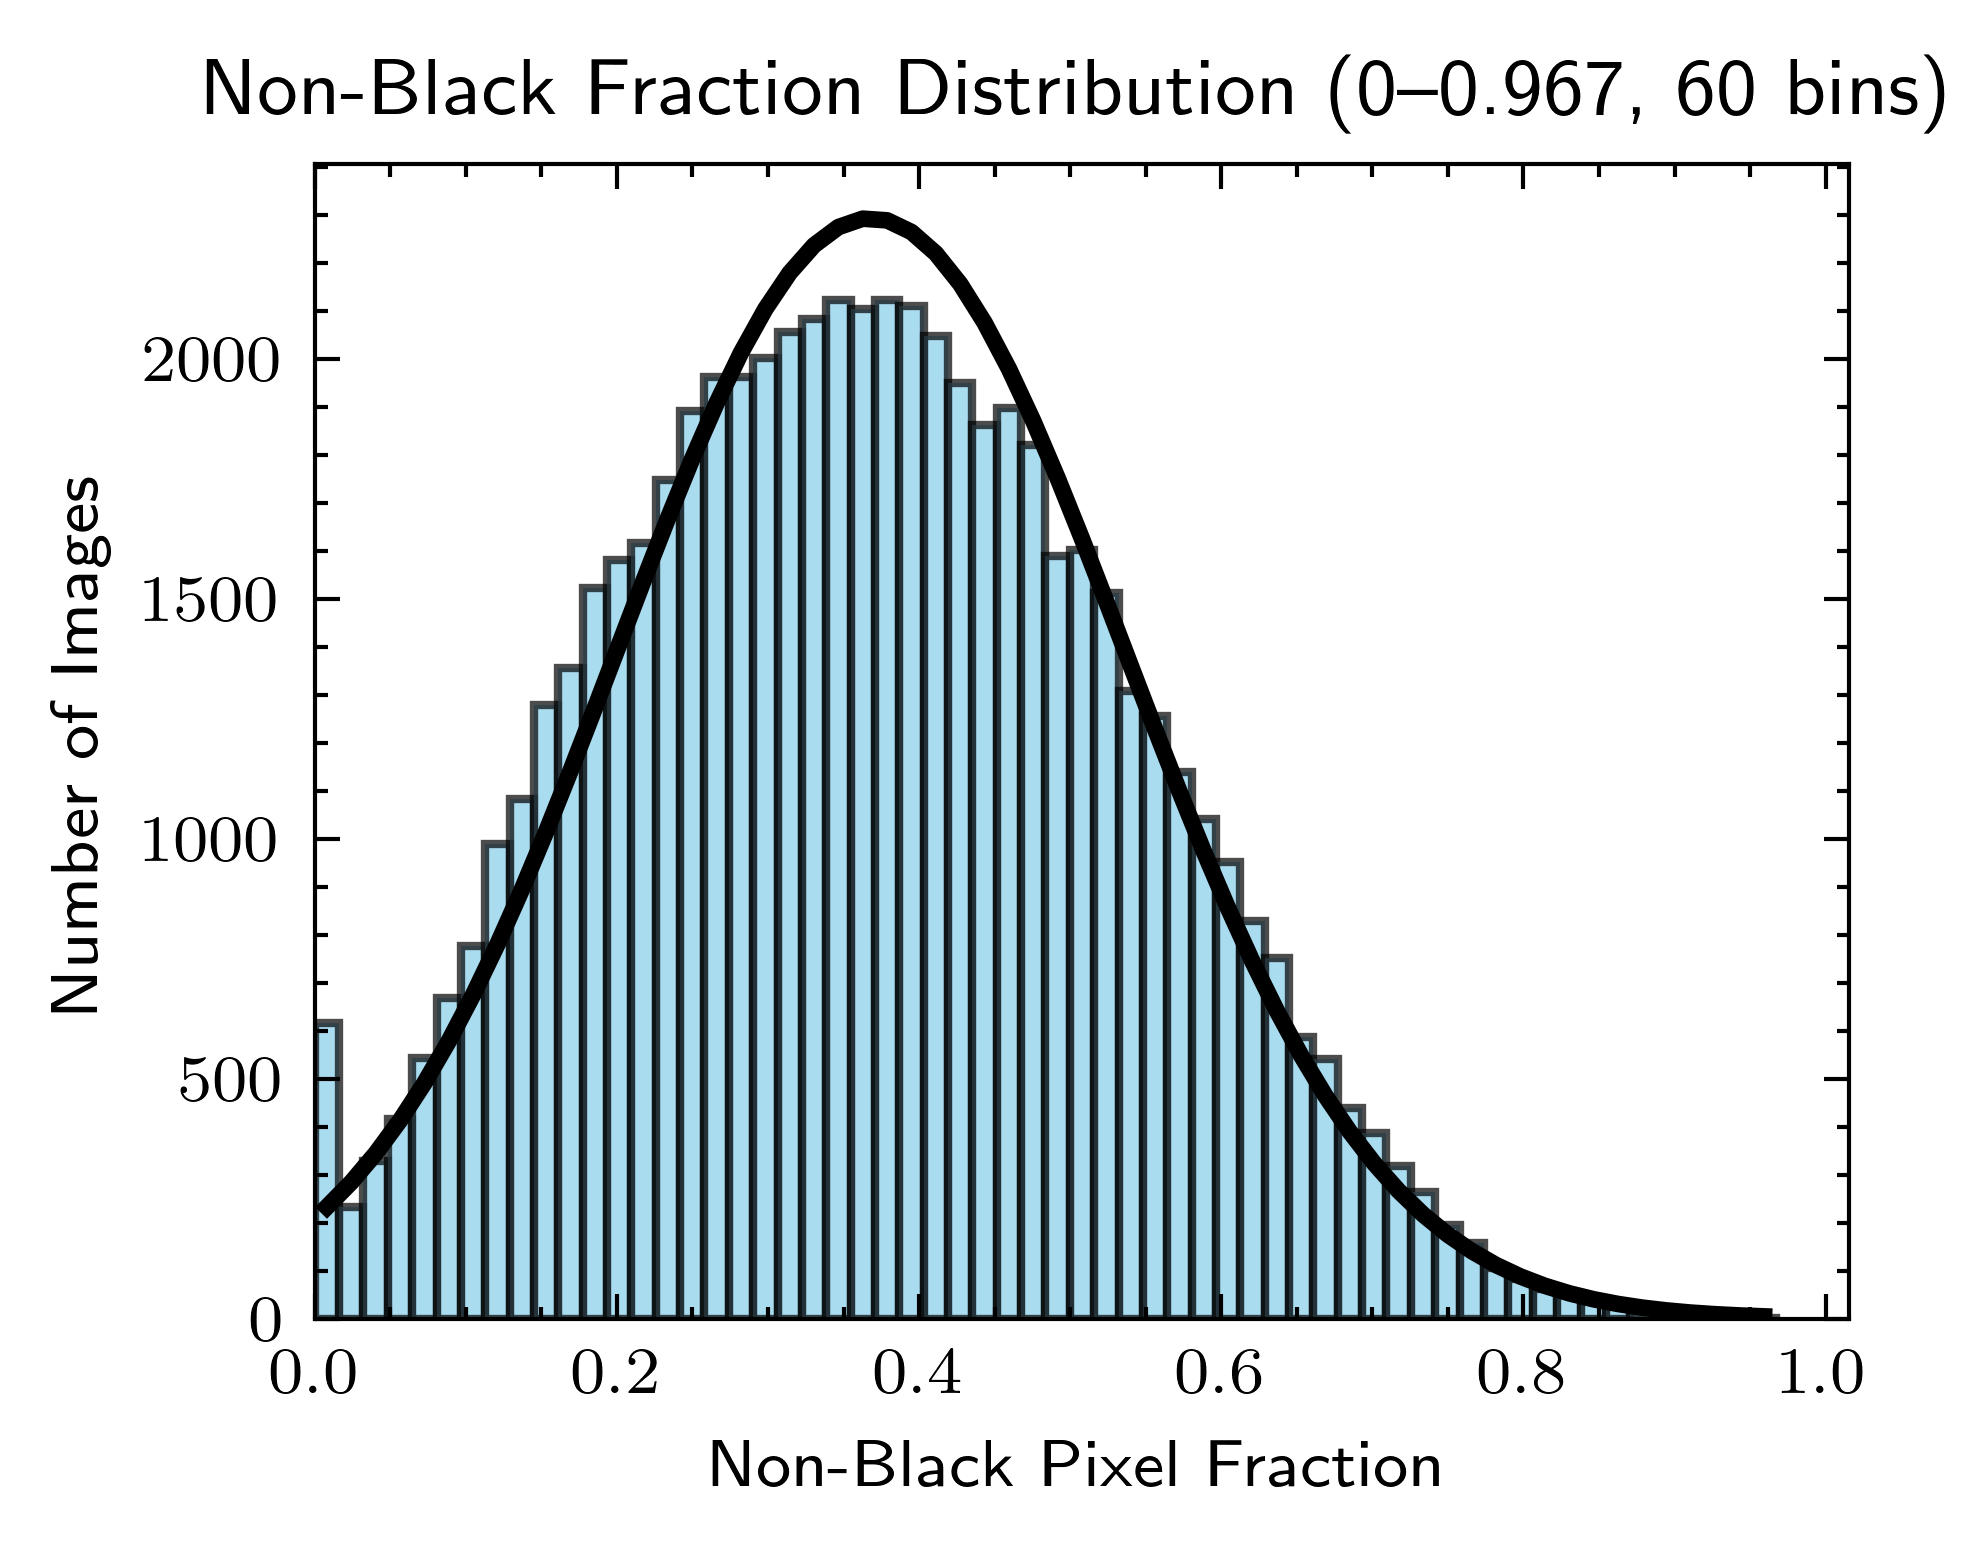

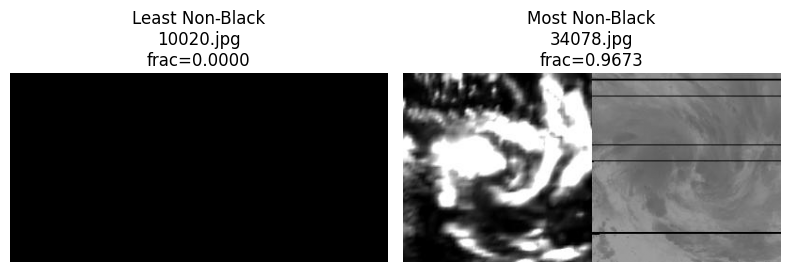

In [9]:
THRESHOLD = 0

file_paths = np.array(glob.glob('./data/TCIRRP/train/*.jpg'))
fractions = []
for p in file_paths:
    img = np.array(Image.open(p).convert('L'))
    w = img.shape[1] // 2
    real = img[:, :w]
    fractions.append((real > THRESHOLD).sum() / real.size)
fractions = np.array(fractions)

N_BINS = 60
max_frac = fractions.max()
bins = np.linspace(0, max_frac, N_BINS + 1)

hist_counts, _ = np.histogram(fractions, bins=bins)

mu, sigma = fractions.mean(), fractions.std()
centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]
pdf_vals = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((centers - mu) / sigma) ** 2)
pdf_counts = pdf_vals * len(fractions) * bin_width
select_counts = np.round(pdf_counts).astype(int)

bin_idx = np.digitize(fractions, bins) - 1
bin_idx = np.clip(bin_idx, 0, N_BINS - 1)

selected = []
rng = np.random.default_rng(1234)
for b in range(N_BINS):
    in_bin = np.where(bin_idx == b)[0]
    n_keep = select_counts[b]
    if len(in_bin) == 0 or n_keep <= 0:
        continue
    chosen = rng.choice(in_bin, size=min(len(in_bin), n_keep), replace=False)
    selected.extend(chosen)
selected = np.array(selected)

edges = [0, 0.05, 0.24, 0.4, max_frac]
labels = ["0–0.05", "0.05–0.24", "0.24–0.4", f"0.4–{max_frac:.3f}"]
out_dir = "./splits_gauss_limited"
os.makedirs(out_dir, exist_ok=True)

for i, (low, hi) in enumerate(zip(edges[:-1], edges[1:]), start=1):
    mask = (fractions[selected] > low) & (fractions[selected] <= hi)
    chosen_idx = selected[mask]
    paths = file_paths[chosen_idx]
    print(f"{labels[i-1]:10s} -> selecting {len(paths)} images")
    with open(os.path.join(out_dir, f"subset_{i}.txt"), 'w') as f:
        f.write("\n".join(paths))

print(f"Mean (μ) = {mu:.4f}, Std Dev (σ) = {sigma:.4f}")

with plt.style.context(["science", "ieee"]):
    fig, ax = plt.subplots()
    counts, bins_plot, patches = ax.hist(
        fractions,
        bins=bins,
        density=False,
        alpha=0.7,
        edgecolor='k',
        color='skyblue',
    )
    pdf_counts = pdf_vals * len(fractions) * bin_width
    ax.plot(centers, pdf_counts, linewidth=2)
    ax.set_xlim(0, max_frac * 1.05)
    ax.set_title(f"Non-Black Fraction Distribution (0–{max_frac:.3f}, {N_BINS} bins)")
    ax.set_xlabel("Non-Black Pixel Fraction")
    ax.set_ylabel("Number of Images")
    plt.savefig("white_fraction_fine.pdf", dpi=150)
    print("Saved zoomed histogram as white_fraction_fine.png")

min_idx = np.argmin(fractions)
max_idx = np.argmax(fractions)
min_path = file_paths[min_idx]
max_path = file_paths[max_idx]
min_frac = fractions[min_idx]
max_frac = fractions[max_idx]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
img_min = Image.open(min_path).convert('L')
axes[0].imshow(img_min, cmap='gray')
axes[0].set_title(f"Least Non-Black\n{os.path.basename(min_path)}\nfrac={min_frac:.4f}")
axes[0].axis('off')

img_max = Image.open(max_path).convert('L')
axes[1].imshow(img_max, cmap='gray')
axes[1].set_title(f"Most Non-Black\n{os.path.basename(max_path)}\nfrac={max_frac:.4f}")
axes[1].axis('off')

plt.tight_layout()
plt.savefig("extreme_images.png", dpi=150)


**8×8 Heatmap of Average Raw Intensities**

Compute the average raw intensity (before normalization) in an 8×8 grid for each rain image and generate a heatmap aggregating all images.


Saved heatmap as: heatmap_raw_8x8.png


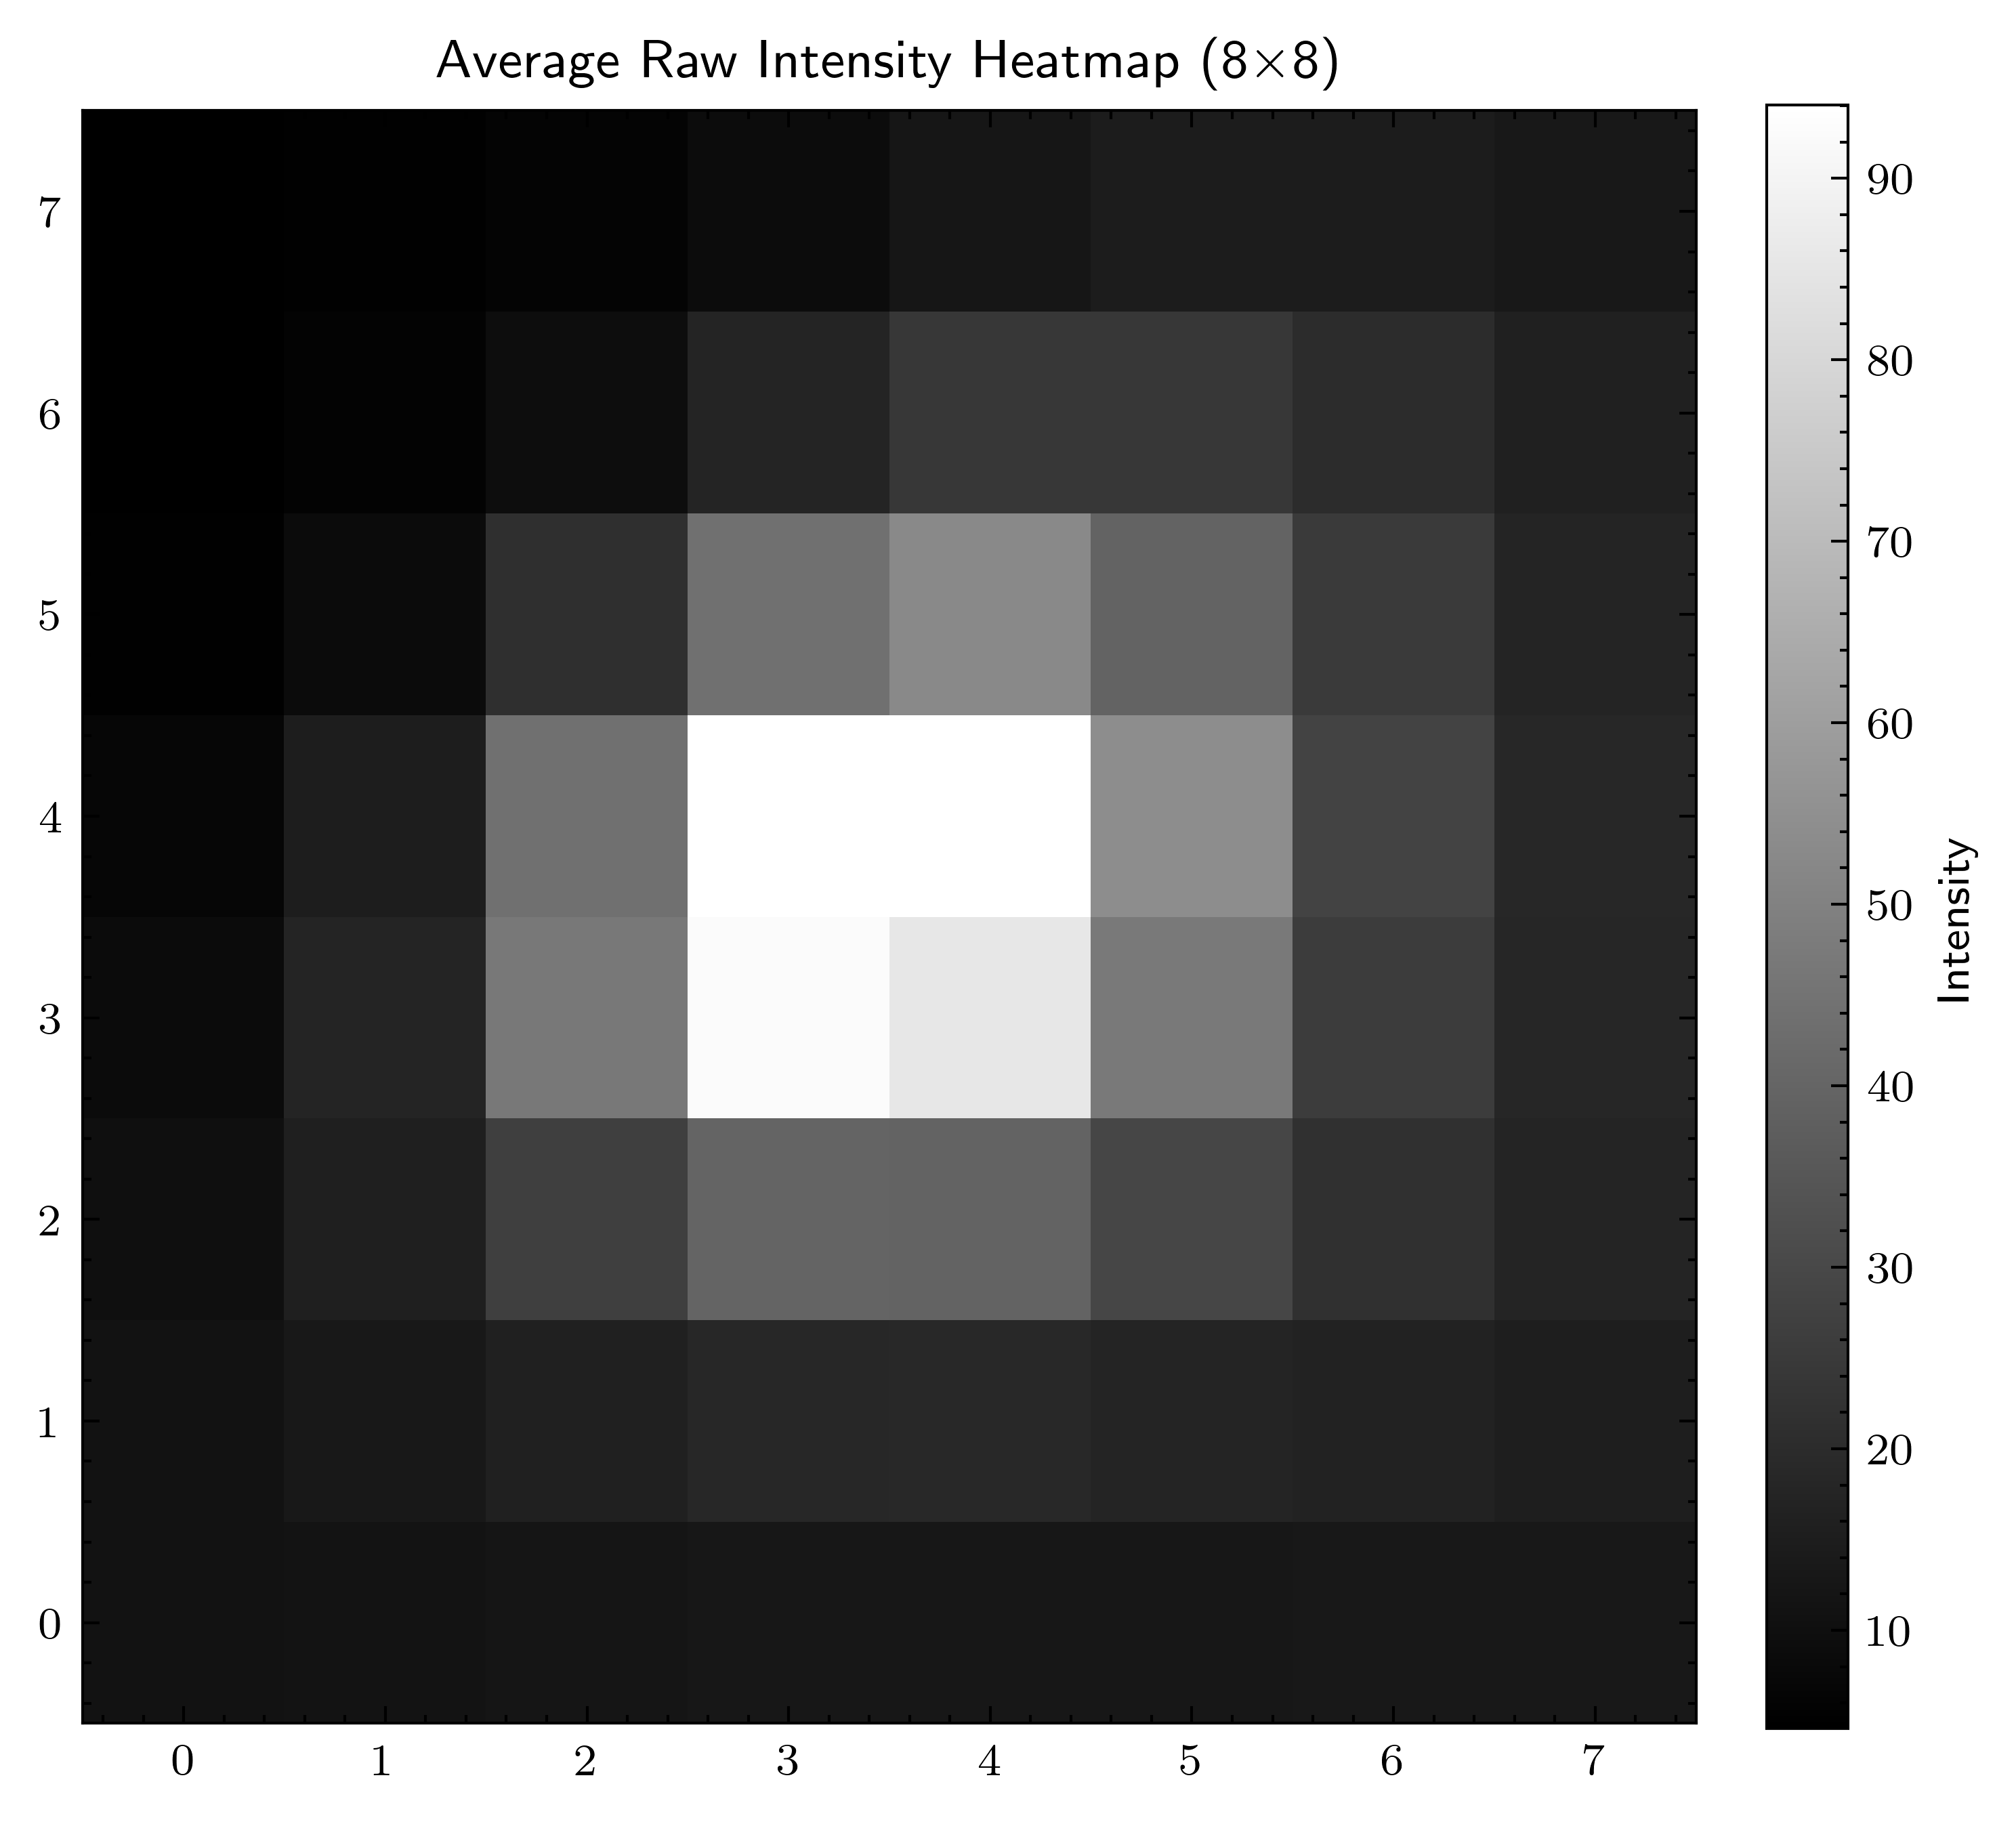

In [10]:
file_paths = glob.glob('./data/TCIRRP/train/*.jpg')
if len(file_paths) == 0:
    raise FileNotFoundError("No images found in the specified path.")

GRID_SIZE = 8
accumulated_raw = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float64)
num_images = 0

for p in file_paths:
    img = np.array(Image.open(p).convert('L'))
    w = img.shape[1] // 2
    real = img[:, :w]

    H, W = real.shape
    cell_h = H // GRID_SIZE
    cell_w = W // GRID_SIZE

    real_cropped_raw = real[: cell_h * GRID_SIZE, : cell_w * GRID_SIZE]
    grid_raw = real_cropped_raw.reshape(GRID_SIZE, cell_h, GRID_SIZE, cell_w)
    per_cell_raw = grid_raw.mean(axis=(1, 3))
    accumulated_raw += per_cell_raw

    num_images += 1

dataset_mean_raw = accumulated_raw / num_images

with plt.style.context(["science", "ieee"]):
    plt.figure(figsize=(5, 5))
    im = plt.imshow(dataset_mean_raw, cmap='gray', origin='lower')
    plt.title('Average Raw Intensity Heatmap (8×8)')
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Intensity')
    plt.tight_layout()
    plt.savefig('heatmap_raw_8x8.pdf', dpi=300)
    print("Saved heatmap as: heatmap_raw_8x8.png")


**Entropy Calculation and Splitting by Quartiles**

Compute Shannon entropy for the left half of each image, determine quartiles, and split the dataset into four subsets based on entropy. Save the file paths in text files and plot the entropy histogram.


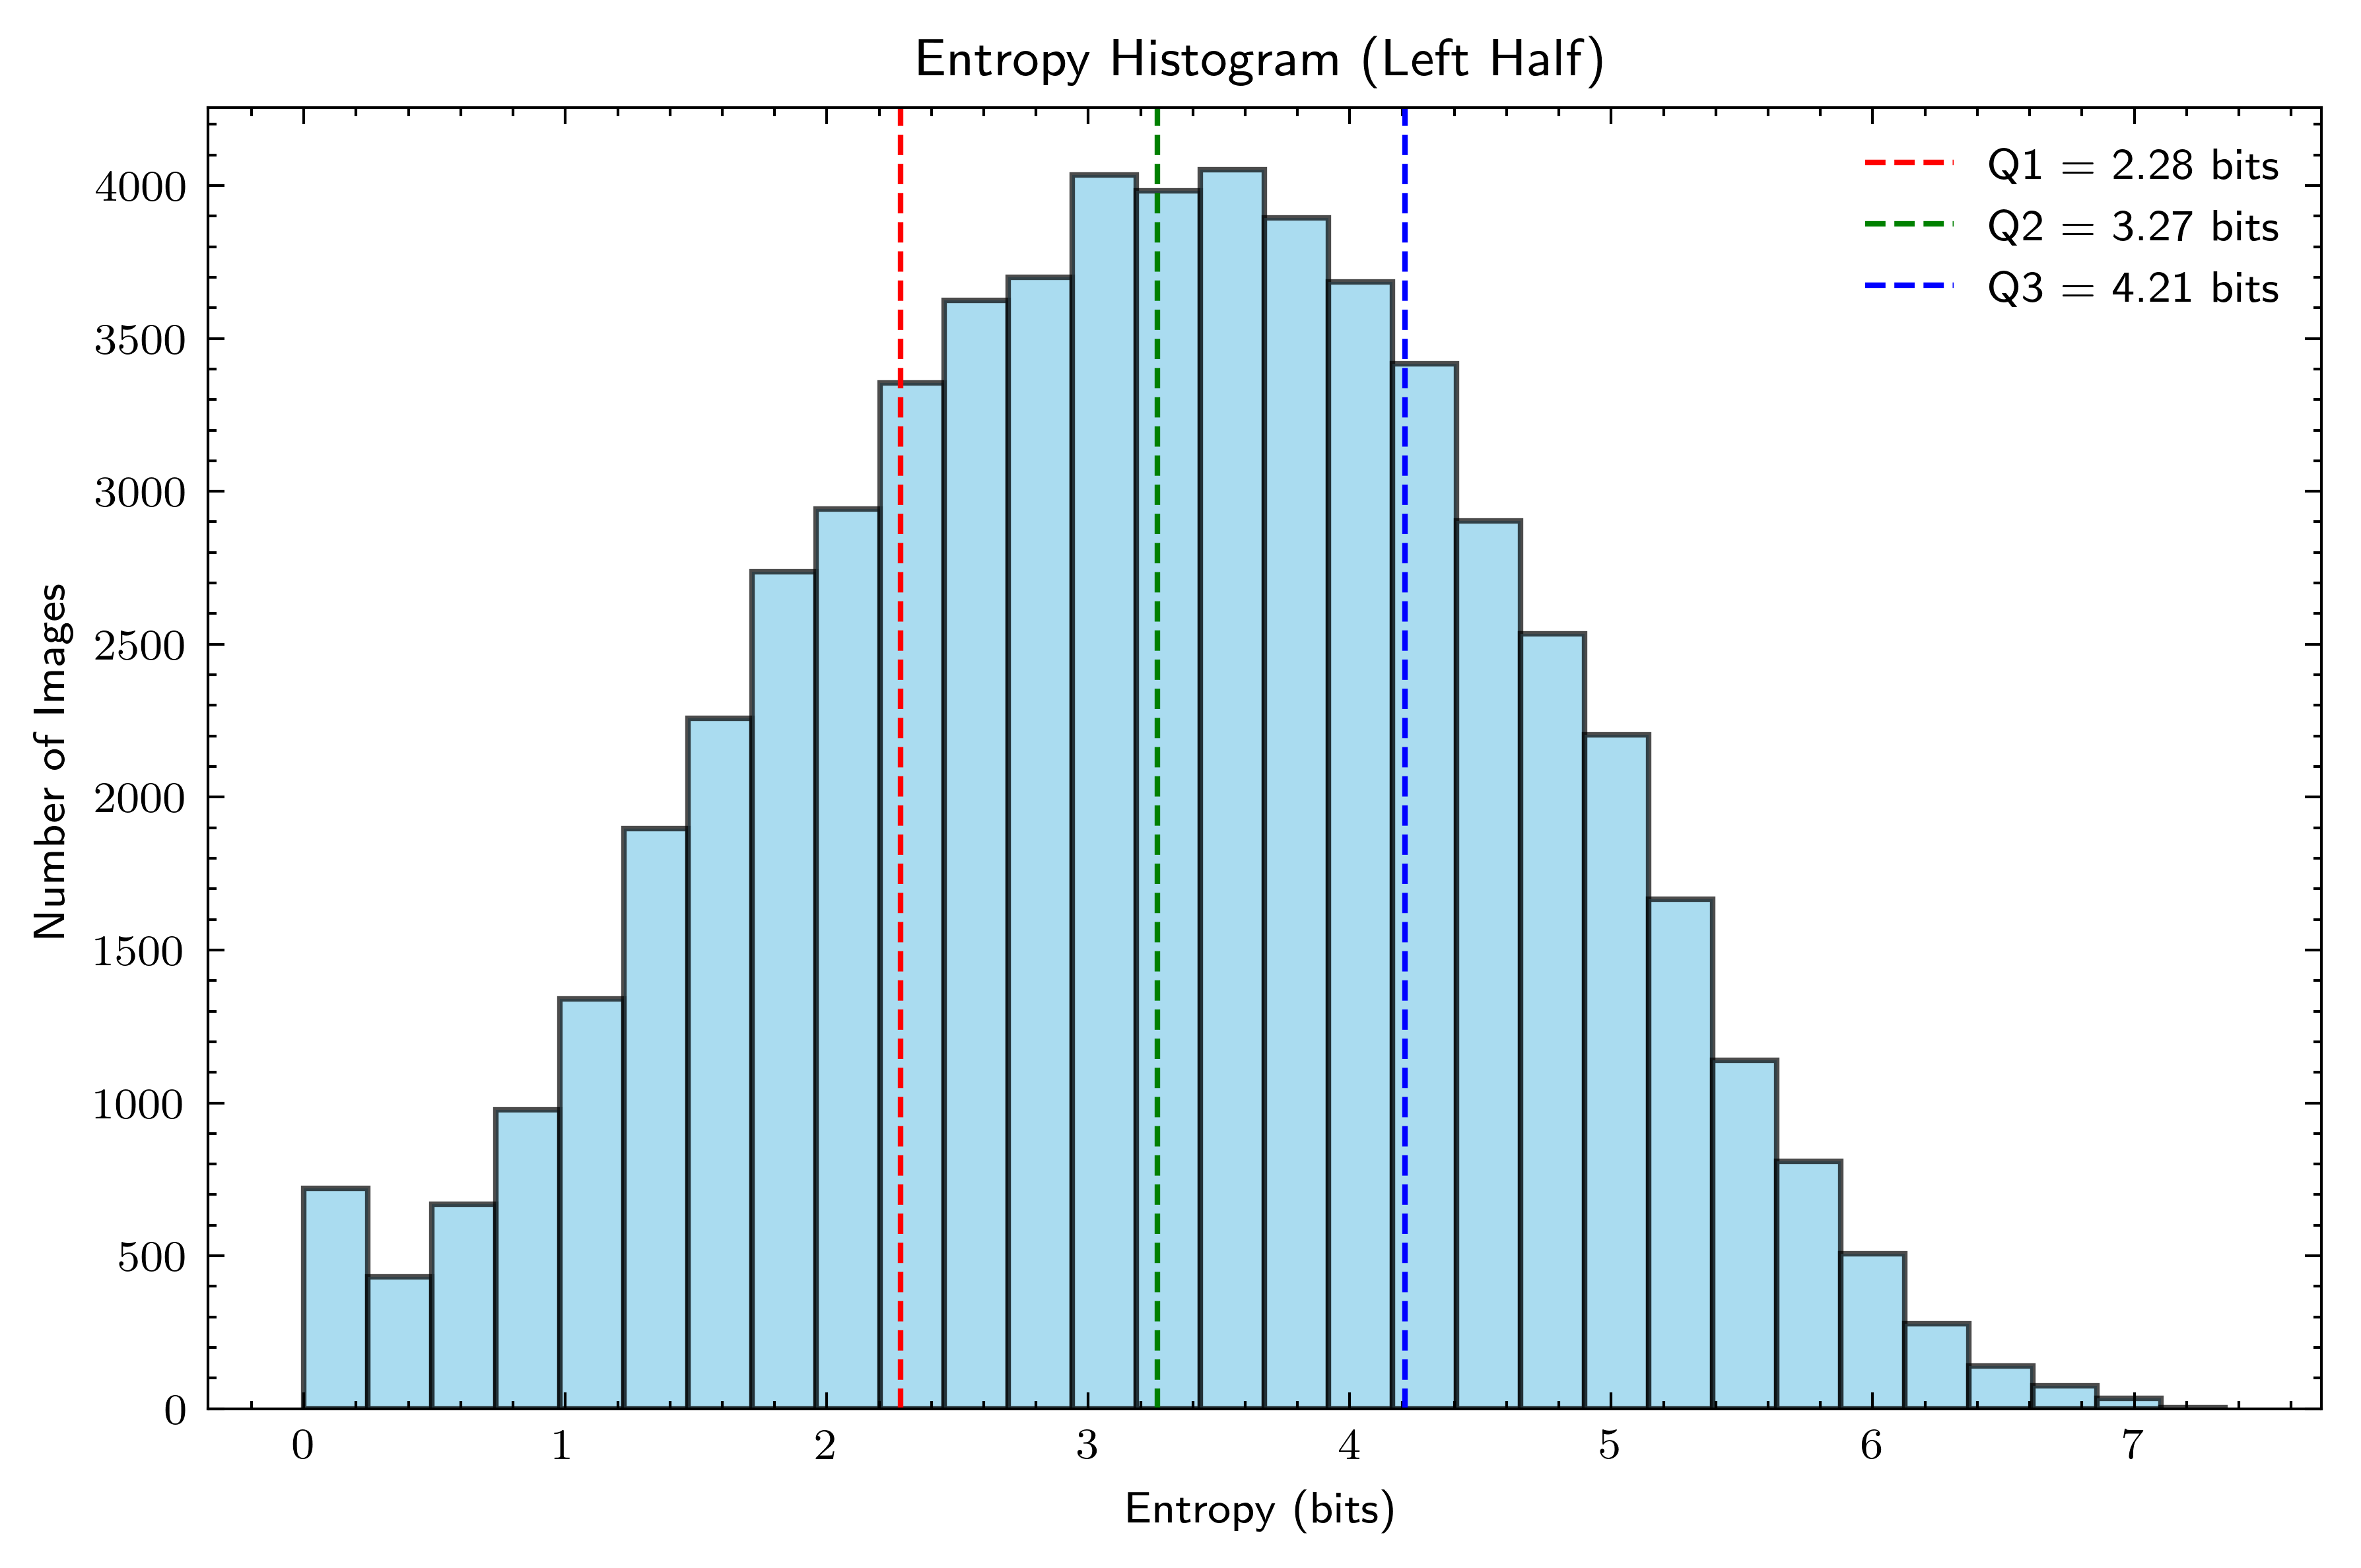

In [11]:
def shannon_entropy_from_histogram(probs: np.ndarray) -> float:
    probs_positive = probs[probs > 0]
    return -np.sum(probs_positive * np.log2(probs_positive))

def entropy_of_gray_image(gray_img: np.ndarray, num_bins: int = 256) -> float:
    if gray_img.dtype != np.uint8:
        img_float = gray_img.astype(np.float32)
        img_norm = (img_float - img_float.min()) / (img_float.max() - img_float.min() + 1e-12)
        img_scaled = (img_norm * 255.0).astype(np.uint8)
    else:
        img_scaled = gray_img
    hist, _ = np.histogram(img_scaled, bins=num_bins, range=(0, 256), density=False)
    probs = hist.astype(np.float32) / hist.sum()
    return shannon_entropy_from_histogram(probs)

def entropy_of_left_half(path: str, num_bins: int = 256) -> float:
    img = Image.open(path).convert('L')
    img_np = np.array(img)
    h, w = img_np.shape
    half = w // 2
    left_half = img_np[:, :half]
    return entropy_of_gray_image(left_half, num_bins=num_bins)

folder_pattern = './data/TCIRRP/train/*.jpg'
image_paths = sorted(glob.glob(folder_pattern))
if len(image_paths) == 0:
    raise RuntimeError(f"No images found in: {folder_pattern}")

entropies = []
for p in image_paths:
    H = entropy_of_left_half(p, num_bins=256)
    entropies.append(H)
entropies = np.array(entropies, dtype=np.float32)

q1 = np.percentile(entropies, 25)
q2 = np.percentile(entropies, 50)
q3 = np.percentile(entropies, 75)

idx_sub1 = np.where(entropies <= q1)[0]
idx_sub2 = np.where((entropies > q1) & (entropies <= q2))[0]
idx_sub3 = np.where((entropies > q2) & (entropies <= q3))[0]
idx_sub4 = np.where(entropies > q3)[0]

subsets_idx = [idx_sub1, idx_sub2, idx_sub3, idx_sub4]
subset_labels = ['subset_1', 'subset_2', 'subset_3', 'subset_4']

out_dir = './splits_by_entropy'
os.makedirs(out_dir, exist_ok=True)
for label, idxs in zip(subset_labels, subsets_idx):
    paths = [image_paths[i] for i in idxs]
    txt_path = os.path.join(out_dir, f"{label}.txt")
    with open(txt_path, 'w') as f:
        f.write("\n".join(paths))

with plt.style.context(["science", "ieee"]):
    plt.figure(figsize=(6, 4))
    counts, bins, patches = plt.hist(
        entropies,
        bins=30,
        edgecolor='k',
        alpha=0.7,
        color='skyblue',
    )
    plt.axvline(q1, color='r', linestyle='--', label=f"Q1 = {q1:.2f} bits")
    plt.axvline(q2, color='g', linestyle='--', label=f"Q2 = {q2:.2f} bits")
    plt.axvline(q3, color='b', linestyle='--', label=f"Q3 = {q3:.2f} bits")
    plt.title("Entropy Histogram (Left Half)")
    plt.xlabel("Entropy (bits)")
    plt.ylabel("Number of Images")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'entropy_histogram.pdf'), dpi=150)
